In [1]:
import scvelo as scv
import scanpy as sc
import velocyto as vcy
import cellrank as cr
import loompy as lp

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d

import numpy as np
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt

import os
import sys
import logging

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=100, frameon=False)
cr.settings.verbosity = 2

#### Load Anndata

In [2]:
# data directory and files for pre-prared anndata
data_dir = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/'
all_samples_path = os.path.join(data_dir, 'aging_all/objects/major_celltype_seurat.h5ad')

AnnData object with n_obs × n_vars = 40106 × 20513
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition'
    var: 'highly_variable'
    uns: 'harmony', 'pca'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs', 'harmony'
    layers: 'counts'
    obsp: 'nn', 'snn'


/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


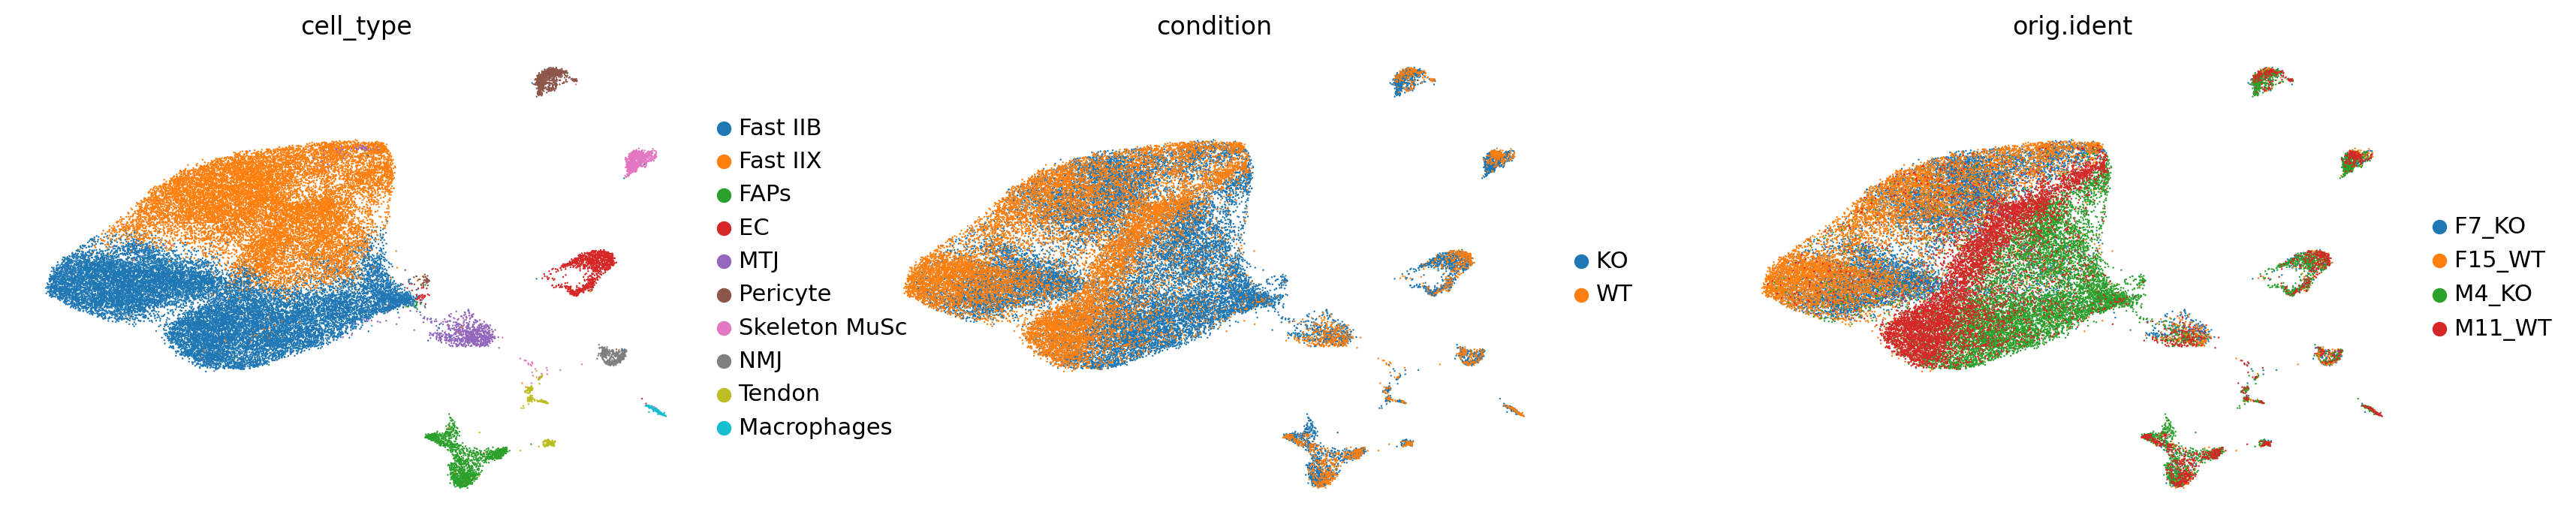

In [49]:
adata_rna = sc.read_h5ad(all_samples_path)
print(adata_rna)
#umap colors by both cell metadata and var.names (gene_names)
sc.pl.umap(adata_rna, color=['cell_type', 'condition', 'orig.ident'], frameon=False) 

#### Load loom files

In [5]:
# data directory and files for velocyto outputs
# sample_F7 (10,212)
data_dir_F7 = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/aging_F7/velocyto'
loom_file_F7 = os.path.join(data_dir_F7, 'aging_F7.loom')
# sample_F15 (9,716)
data_dir_F15 = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/aging_F15/velocyto'
loom_file_F15 = os.path.join(data_dir_F15, 'aging_F15.loom')
# sample M_4 (12,129)
data_dir_M4 = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/aging_M4/velocyto'
loom_file_M4 = os.path.join(data_dir_M4, 'aging_M4.loom')
# sample M_11 (8,239)
data_dir_M11 = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/aging_M11/velocyto'
loom_file_M11 = os.path.join(data_dir_M11, 'aging_M11.loom')

In [5]:
# Create an analysis object using loompy {gene by cell matrix}
ds = lp.connect(loom_file_M11)
print(ds.shape)
# List all available layers in the LayerManager object
print(ds.layers.keys())
# Global attributes
print(ds.attrs.keys())
# Obs for each gene and cell
print(ds.ra.keys()); print(ds.ca.keys())
# graphs if saved in the loom (most prob not)
ds.close() # at the end of the analysis so that the hdf5 is not corrputed


(32285, 8239)
['', 'ambiguous', 'spliced', 'unspliced']
['CreationDate', 'LOOM_SPEC_VERSION', 'velocyto.__version__', 'velocyto.logic']
['Accession', 'Chromosome', 'End', 'Gene', 'Start', 'Strand']
['CellID', 'Clusters']


#### Load created anndata with loomdata for all samples

In [6]:
# load the anndata object
adata_with_vcy_KO = sc.read_h5ad(os.path.join(data_dir, 'aging_all/objects/adata_with_vcy_KO.h5ad'))

In [7]:
adata_with_vcy_KO

AnnData object with n_obs × n_vars = 22187 × 20500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'sample_batch', 'Clusters', '_X', '_Y', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'highly_variable', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'spearmans_score', 'velocity_score'
    uns: 'cell_type_colors', 'cell_type_sizes', 'condition_colors', 'harmony', 'log1p', 'neighbors', 'paga', 'pca', 'rank_velocity_genes', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'harmony'
    layers: 'Ms', 'Mu', 'ambiguous', 'counts

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


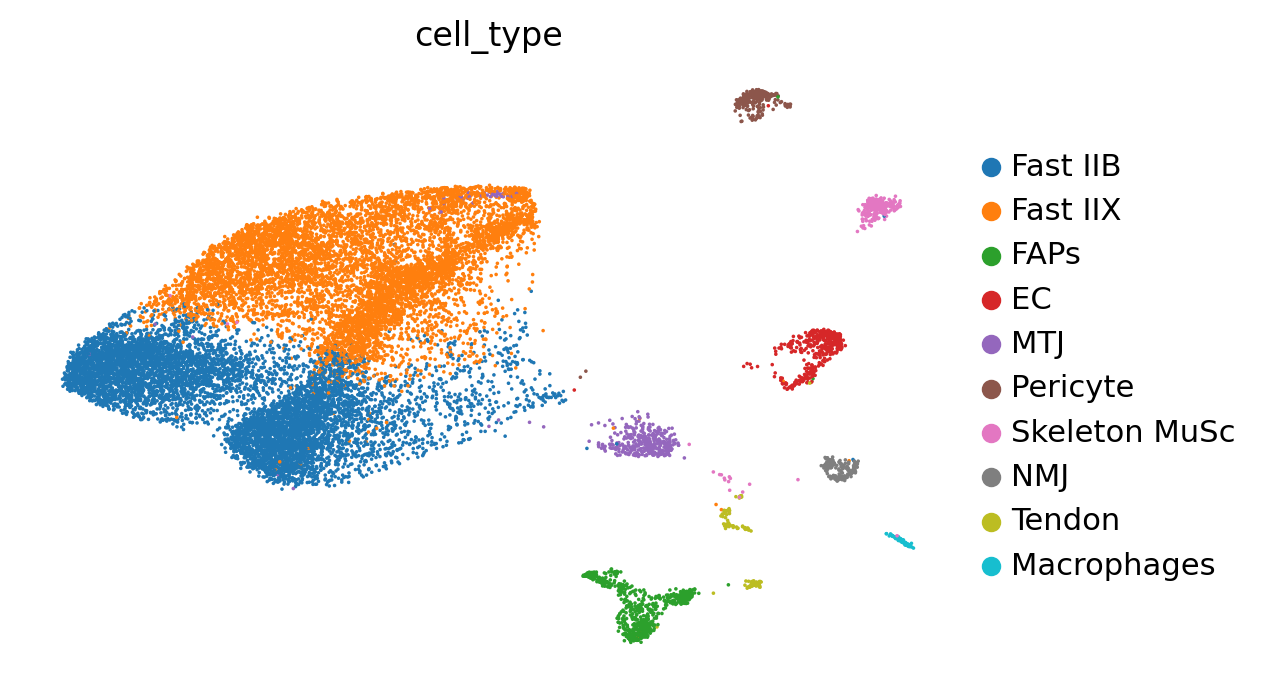

In [52]:
# plot umap to check
sc.pl.umap(adata_with_vcy_WT, color=['cell_type'], frameon=False)

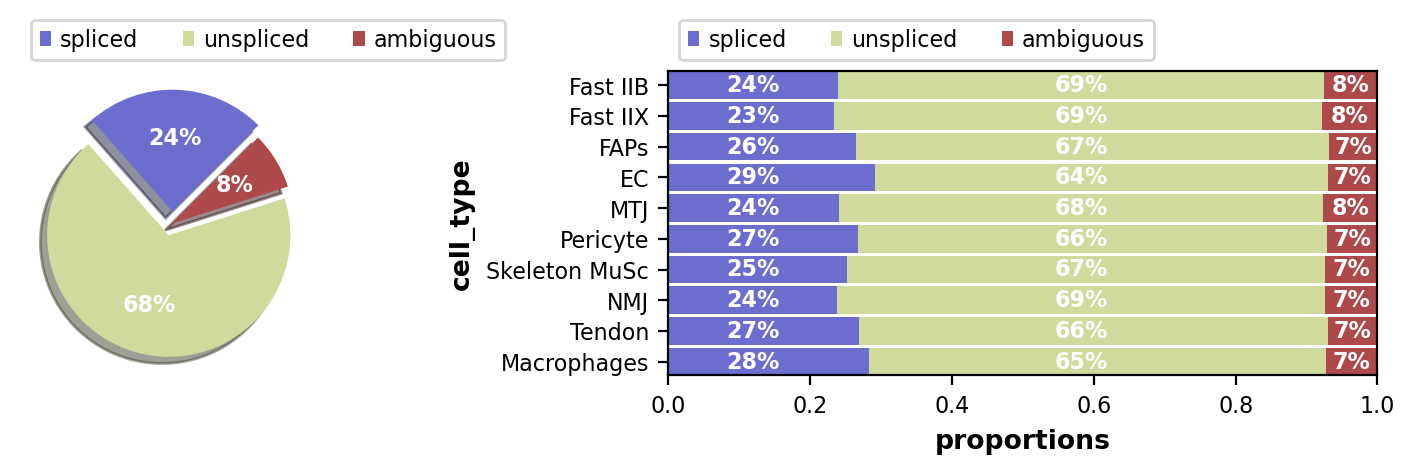

In [53]:
scv.pl.proportions(adata_with_vcy_WT, groupby='cell_type')

In [54]:
# pre-process the data
scv.pp.filter_and_normalize(adata_with_vcy_WT)
scv.pp.moments(adata_with_vcy_WT)

Normalized count data: spliced, unspliced.


/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


Logarithmized X.
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:13) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [55]:
# compute velocity
scv.tl.velocity(adata_with_vcy_WT, mode='stochastic')
scv.tl.velocity_graph(adata_with_vcy_WT)

computing velocities
    finished (0:00:25) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/128 cores)


  0%|          | 0/17919 [00:00<?, ?cells/s]

    finished (0:01:37) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:05) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


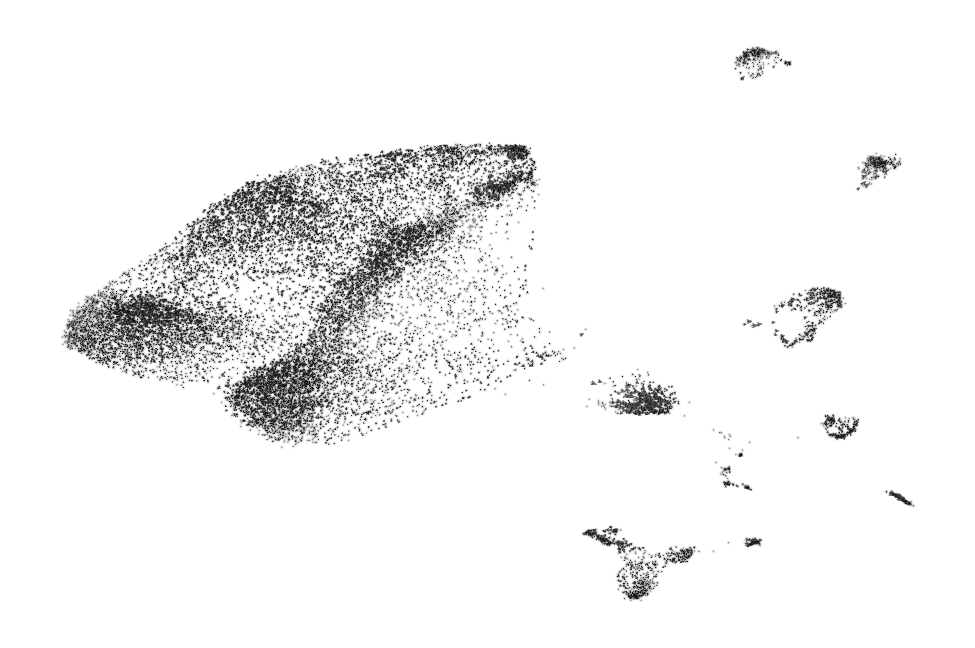

In [56]:
scv.pl.velocity_embedding(adata_with_vcy_WT, basis='umap', frameon=False)

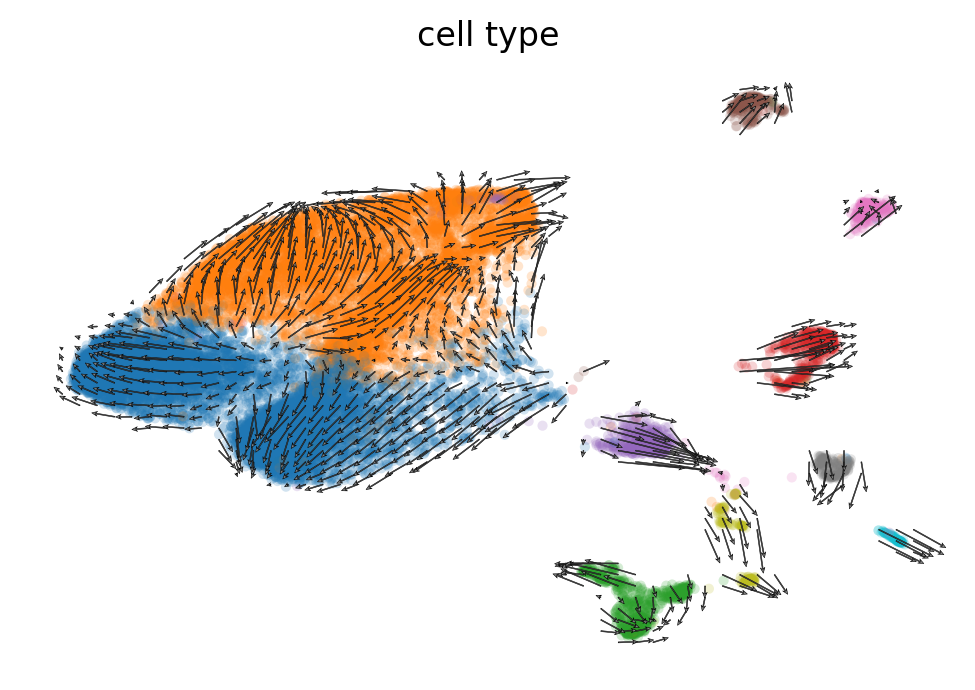

In [57]:
scv.pl.velocity_embedding_grid(adata_with_vcy_WT, basis='umap', color='cell_type', scale=0.25)

saving figure to file ./figures/scvelo_embedding_stream_WT.pdf


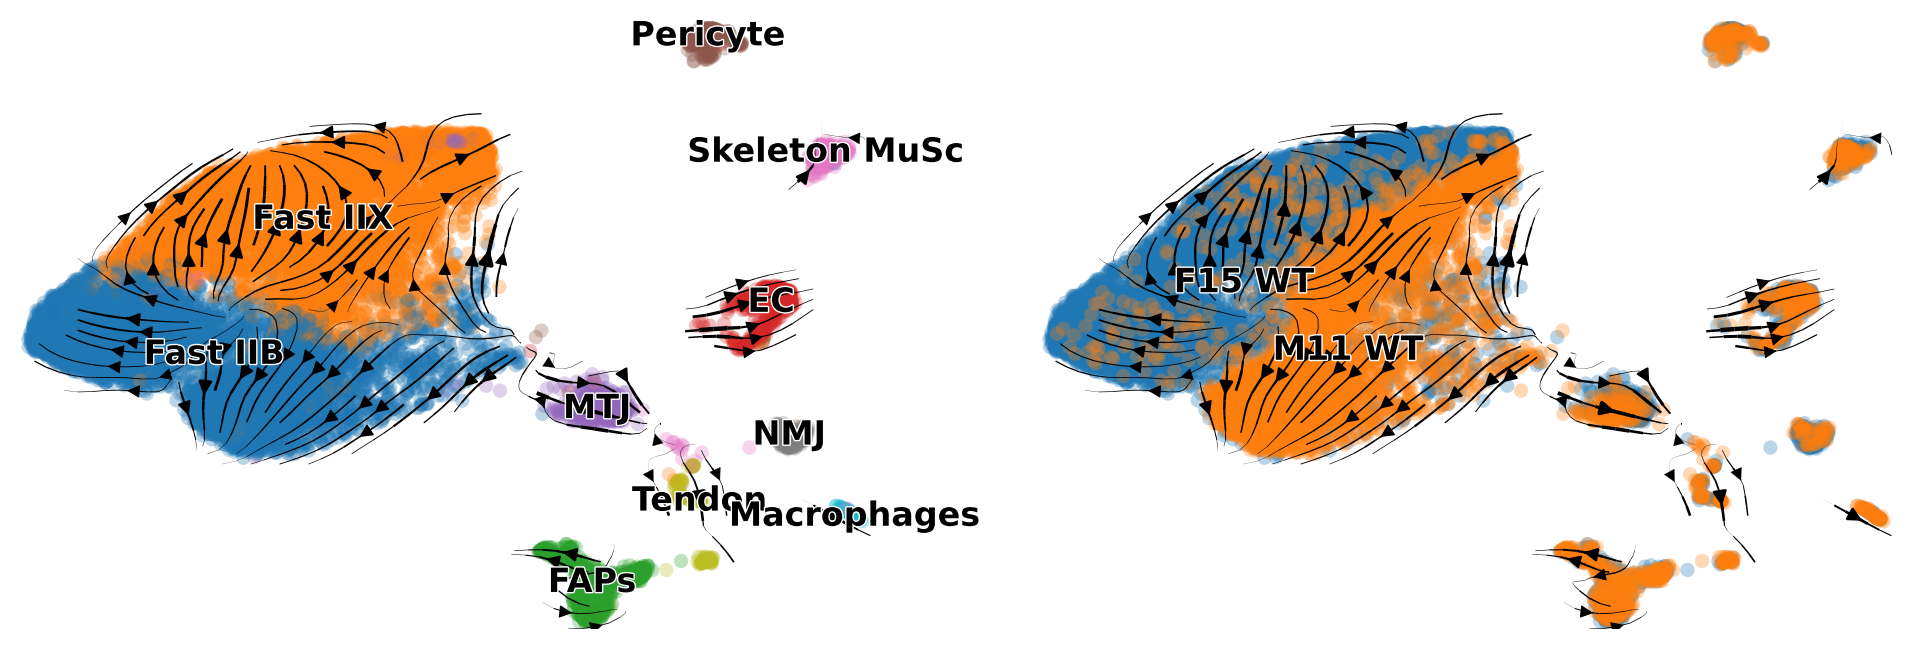

In [58]:
scv.pl.velocity_embedding_stream(adata_with_vcy_WT, basis='umap', color=['cell_type', 'orig.ident'], save='embedding_stream_WT.pdf', title='')

#### Pseudotime trajectory inference

In [8]:
scv.tl.rank_velocity_genes(adata_with_vcy_KO, groupby='cell_type', min_corr=.3)
#save dataframe csv
pd.DataFrame(adata_with_vcy_KO.uns["rank_velocity_genes"]["names"]).to_csv(os.path.join(data_dir, 'velocity_results/ranked_velocity_genes_WT.csv'))
print(pd.DataFrame(adata_with_vcy_KO.uns["rank_velocity_genes"]["names"]).head(10))


ranking velocity genes
    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
  Fast IIB Fast IIX     FAPs       EC      MTJ Pericyte  Skeleton MuSc  \
0    Mylk4     Ank2    Slit3    Myo1d      App    Opcml           Ror1   
1    Phka1     Myh1    Man1a    Prex2  Ldlrad3    Ptprk         Sema6a   
2   Pfkfb3    Actn2  Runx1t1    Dock1     Rgcc    Pakap         Megf10   
3    Pde7a    Ppara   Plxdc2    Plcb4    Dapp1    Lin7a          Tshz3   
4      Pcx     Fgf1     Ebf2     Elk3    Lama2    Pde3a  2610307P16Rik   
5    Vldlr  Gm20757    Bicc1  Plekhg1    Pdzd2    Maml3           Bnc2   
6   Sorbs2    Lmcd1   Sh3d19   Ablim1   Usp6nl    Sgip1          Clcn5   
7   Ccdc60    Agbl1   Scara5   Lrrc8c     Scel    Asap2           Pax7   
8     Irs1     Ldhb     Egfr     Fli1   Pdlim3  Slc35f1          Ltbp1   
9    Tacc2     Nrp1   Antxr2     Rin3  Slc24a2   Inpp4b          Sytl2  

In [10]:
adata_with_vcy_KO.uns["rank_velocity_genes"]

{'names': rec.array([('Mylk4', 'Ank2', 'Slit3', 'Myo1d', 'App', 'Opcml', 'Ror1', 'Rbms3', 'Cep112', 'Elmo1'),
            ('Phka1', 'Myh1', 'Man1a', 'Prex2', 'Ldlrad3', 'Ptprk', 'Sema6a', 'Osbpl3', 'Kirrel', 'Iqgap2'),
            ('Pfkfb3', 'Actn2', 'Runx1t1', 'Dock1', 'Rgcc', 'Pakap', 'Megf10', 'Ctdspl', 'Aff3', 'Dse'),
            ('Pde7a', 'Ppara', 'Plxdc2', 'Plcb4', 'Dapp1', 'Lin7a', 'Tshz3', 'Pla2g7', 'Ctdspl', 'Nav1'),
            ('Pcx', 'Fgf1', 'Ebf2', 'Elk3', 'Lama2', 'Pde3a', '2610307P16Rik', 'Calcrl', 'Dock10', 'Acer3'),
            ('Vldlr', 'Gm20757', 'Bicc1', 'Plekhg1', 'Pdzd2', 'Maml3', 'Bnc2', 'Ptprg', 'Runx1t1', 'Gas7'),
            ('Sorbs2', 'Lmcd1', 'Sh3d19', 'Ablim1', 'Usp6nl', 'Sgip1', 'Clcn5', 'Maml3', 'Ptpn13', 'Arhgap22'),
            ('Ccdc60', 'Agbl1', 'Scara5', 'Lrrc8c', 'Scel', 'Asap2', 'Pax7', 'Ncam1', 'Lima1', 'Pip4k2a'),
            ('Irs1', 'Ldhb', 'Egfr', 'Fli1', 'Pdlim3', 'Slc35f1', 'Ltbp1', 'Etv5', 'Sash1', 'Cmah'),
            ('Tacc2', 'Nrp1', 'An

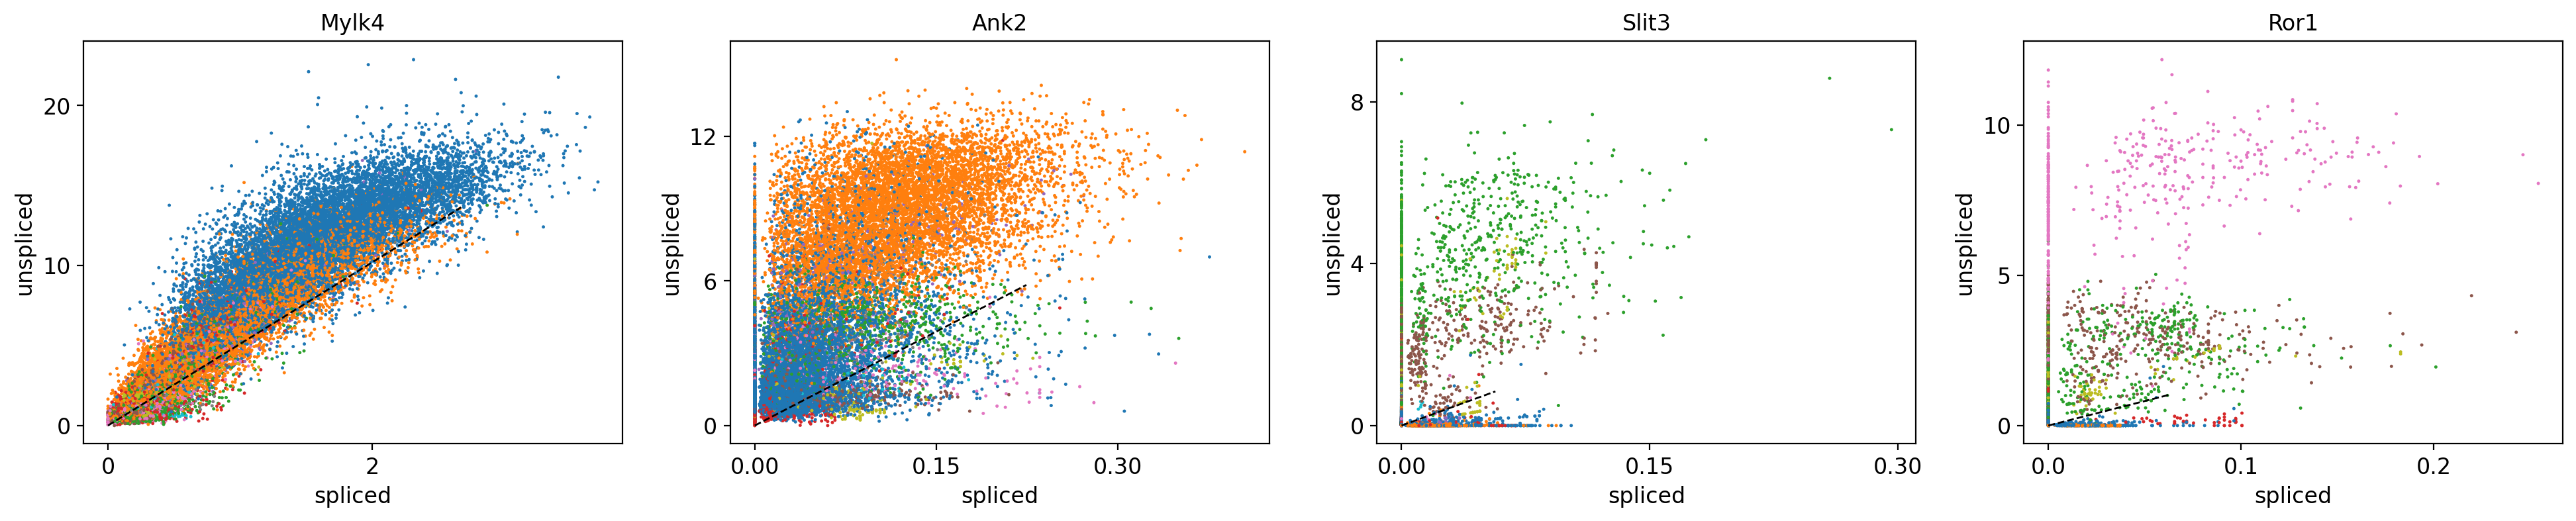

In [16]:
scv.pl.scatter(adata_with_vcy_KO, basis=['Mylk4', 'Ank2', 'Slit3', 'Ror1'], color='cell_type')

In [61]:
scv.tl.velocity_confidence(adata_with_vcy_WT)
# inspect velocity confidence
adata_with_vcy_WT.obs
# plot umap to check
sc.pl.umap(adata_with_vcy_WT, color=['velocity_length', 'velocity_confidence'], frameon=False, save='_velocity_confidence_WT.pdf')

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


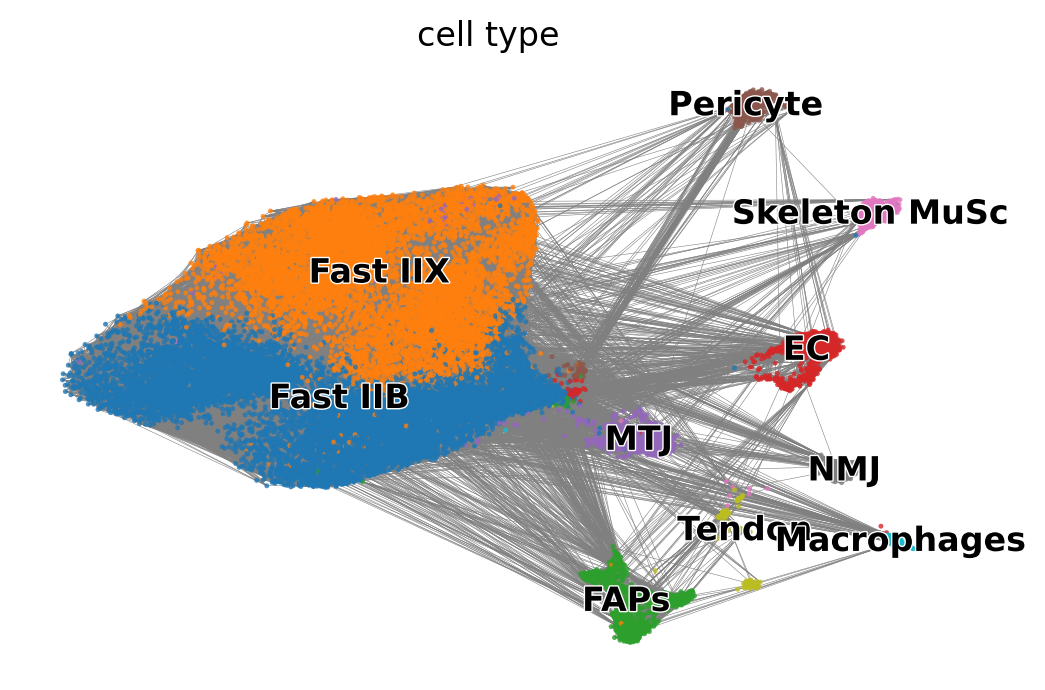

In [5]:
scv.pl.velocity_graph(adata_with_vcy_KO, threshold=.1, color='cell_type')

#### Get pseudo-time

In [63]:
scv.tl.velocity_pseudotime(adata_with_vcy_WT)
adata_with_vcy_WT.obs

computing terminal states
    identified 10 regions of root cells and 7 regions of end points .
    finished (0:00:05) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


orig.ident  nCount_RNA  nFeature_RNA  percent.mt  \
AAACCCAAGACT     F15_WT      6603.0          2194        0.21   
AAACCCAAGCTC     F15_WT      3041.0          1286        0.43   
AAACCCAAGTAG     F15_WT      5952.0          2173        0.40   
AAACCCACAAGA     F15_WT      4285.0          1777        0.77   
AAACCCAGTCGT     F15_WT       652.0           495        5.98   
...                 ...         ...           ...         ...   
TTTGTTGTCAGA     M11_WT      4610.0          1693        0.80   
TTTGTTGTCCCA     M11_WT      6693.0          2115        0.45   
TTTGTTGTCGAA     M11_WT      1897.0           964        0.79   
TTTGTTGTCGAG     M11_WT      5340.0          2031        0.26   
TTTGTTGTCGCC     M11_WT      4494.0          1753        0.27   

              log10GenesPerUMI seurat_clusters RNA_snn_res.0.6      cell_type  \
AAACCCAAGACT              0.87               0               0       Fast IIB   
AAACCCAAGCTC              0.89               1               1       Fast IIX   
AAACCCAAGTAG              0.88               1               1       Fast IIX   
AAACCCACAAGA              0.89               0               0       Fast IIB   
AAACCCAGTCGT              0.96              11              11  Skeleton MuSc   
...                        ...             ...             ...            ...   
TTTGTTGTCAGA              0.88               5               5       Fast IIX   
TTTGTTGTCCCA              0.87               0               0       Fast IIB   
TTTGTTGTCGAA              0.91               4               4       Fast IIB   
TTTGTTGTCGAG              0.89               4               4       Fast IIB   
TTTGTTGTCGCC              0.89               2               2       Fast IIX   

             condition   sample_batch  ... initial_size_spliced  initial_size  \
AAACCCAAGACT        WT  F15_WT_GTTC-1  ...                 1032        1032.0   
AAACCCAAGCTC        WT  F15_WT_CACG-1  ...                  813         813.0   
AAACCCAAGTAG        WT  F15_WT_ACAT-1  ...                  889         889.0   
AAACCCACAAGA        WT  F15_WT_TGTA-1  ...                  829         829.0   
AAACCCAGTCGT        WT  F15_WT_GCCA-1  ...                  255         255.0   
...                ...            ...  ...                  ...           ...   
TTTGTTGTCAGA        WT  M11_WT_GCAG-1  ...                  963         963.0   
TTTGTTGTCCCA        WT  M11_WT_GGCA-1  ...                 1300        1300.0   
TTTGTTGTCGAA        WT  M11_WT_GTGG-1  ...                  499         499.0   
TTTGTTGTCGAG        WT  M11_WT_AGCA-1  ...                  875         875.0   
TTTGTTGTCGCC        WT  M11_WT_TAGG-1  ...                  809         809.0   

              n_counts velocity_self_transition  velocity_length  \
AAACCCAAGACT   2891.22                     0.22             6.63   
AAACCCAAGCTC   2221.00                     0.24            35.23   
AAACCCAAGTAG   2968.64                     0.18            12.78   
AAACCCACAAGA   2757.51                     0.18             9.54   
AAACCCAGTCGT   1453.50                     0.12            13.97   
...                ...                      ...              ...   
TTTGTTGTCAGA   2523.40                     0.17            32.17   
TTTGTTGTCCCA   2780.51                     0.13            11.28   
TTTGTTGTCGAA   2020.48                     0.06             7.35   
TTTGTTGTCGAG   2861.04                     0.17            14.00   
TTTGTTGTCGCC   2633.02                     0.19            17.92   

              velocity_confidence  velocity_confidence_transition  root_cells  \
AAACCCAAGACT                 0.74                            0.03    2.17e-03   
AAACCCAAGCTC                 0.99                            0.11    9.46e-04   
AAACCCAAGTAG                 0.82                            0.24    4.19e-03   
AAACCCACAAGA                 0.83                            0.14    2.49e-03   
AAACCCAGTCGT                 0.72                            0.2

In [64]:
# this is needed due to a current bug - bugfix is coming soon.
adata_with_vcy_WT.uns['neighbors']['distances'] = adata_with_vcy_WT.obsp['distances']
adata_with_vcy_WT.uns['neighbors']['connectivities'] = adata_with_vcy_WT.obsp['connectivities']

In [65]:
scv.tl.paga(adata_with_vcy_WT, groups='cell_type')
df = scv.get_df(adata_with_vcy_WT, 'paga/transitions_confidence', precision=2).T

running PAGA using priors: ['velocity_pseudotime']
    finished (0:02:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


saving figure to file ./figures/scvelo_paga_velocity_cluster_movement_WT.pdf


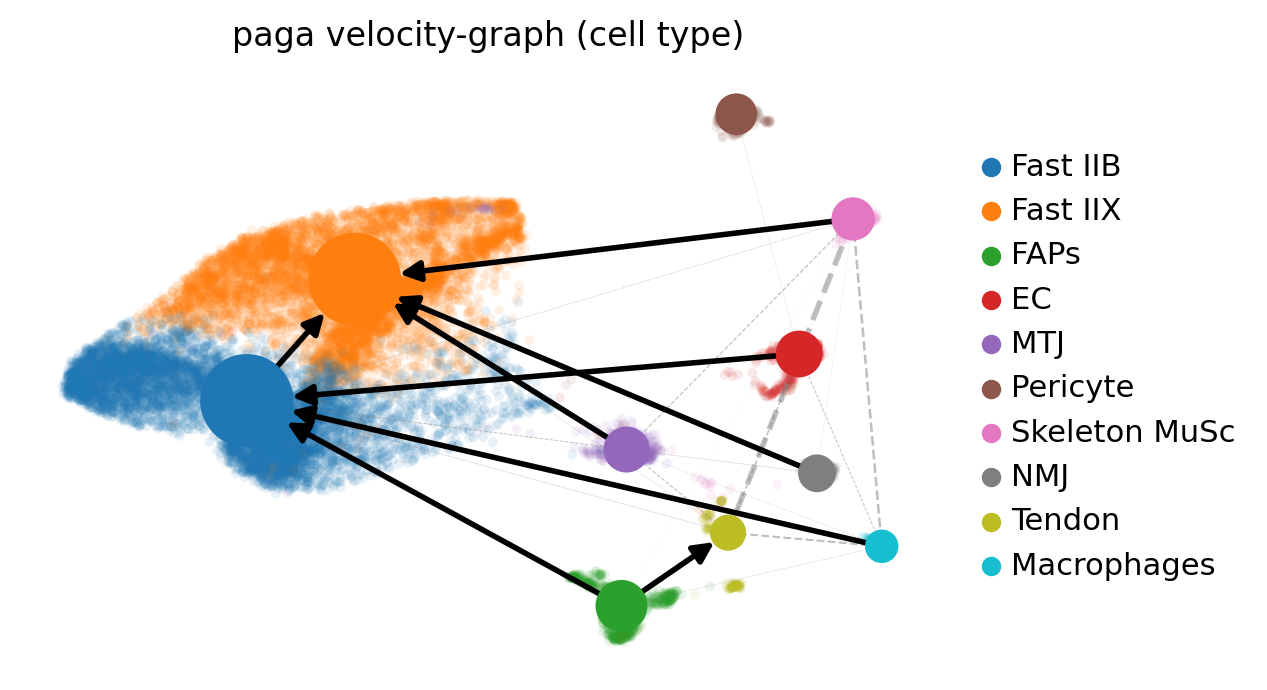

In [66]:
scv.pl.paga(adata_with_vcy_WT, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5, save='paga_velocity_cluster_movement_WT.pdf')

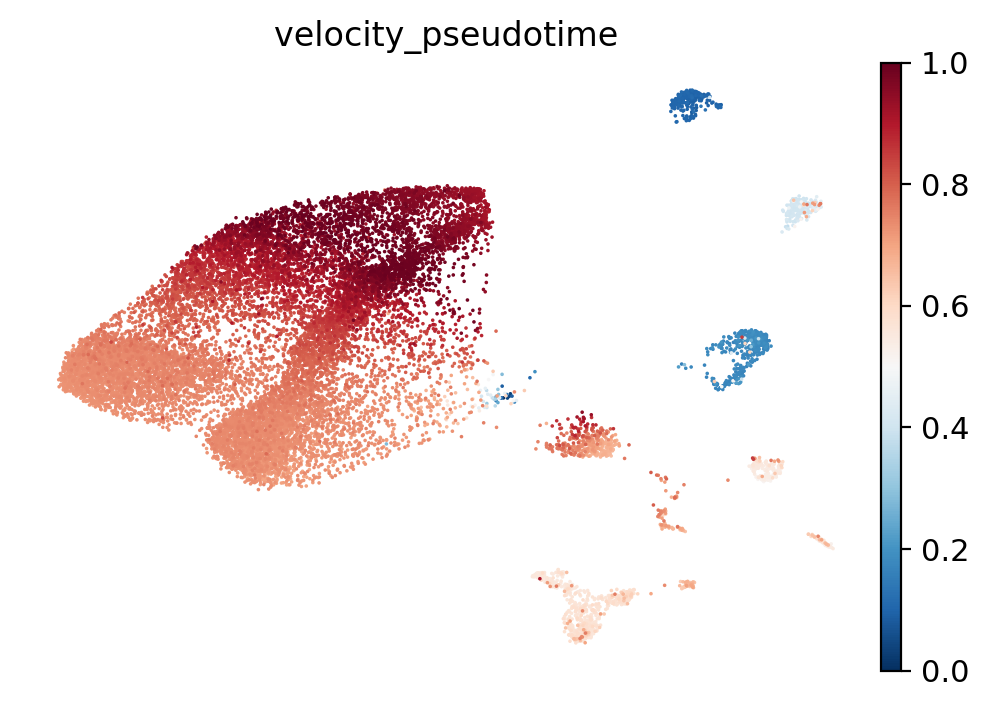

In [67]:
# color by velocity_pseudotime
sc.pl.umap(adata_with_vcy_WT, color=['velocity_pseudotime'], frameon=False)

In [68]:
#save new adata object with velocity calculated 
adata_with_vcy_WT.write(os.path.join(data_dir,'aging_all/objects/adata_with_vcy_WT.h5ad'))